In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import degree
from collections import Counter
import matplotlib.pyplot as plt

In [3]:
dataset = Planetoid(root=".",name="cora")
data = dataset[0]

In [4]:
degrees = degree(data.edge_index[0]).numpy()

In [5]:
numbers = Counter(degrees)

<BarContainer object of 37 artists>

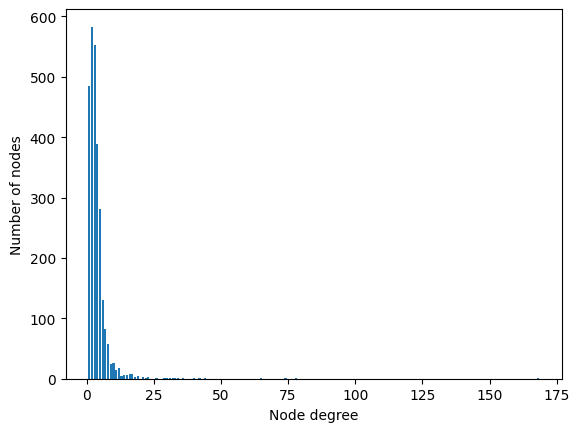

In [6]:
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())

In [7]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

In [8]:
def accuracy(pred_y, y):
    return ((pred_y == y).sum() / len(y)).item()

In [9]:
class GCN(torch.nn.Module):
    """Graph Convolutional Network"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in, dim_h)
        self.gcn2 = GCNConv(dim_h, dim_out)
    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = self.gcn2(h, edge_index)
        return F.log_softmax(h, dim=1)
    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=5e-4)
        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
            loss.backward()
            optimizer.step()
            if(epoch % 20 == 0):
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {loss:3f} | Train Acc: {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')
    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc


In [12]:
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)
gcn.fit(data,epochs=100)

GCN(
  (gcn1): GCNConv(1433, 16)
  (gcn2): GCNConv(16, 7)
)
Epoch   0 | Train Loss: 1.952686 | Train Acc: 17.14% | Val Loss: 1.95 | Val Acc: 16.00%
Epoch  20 | Train Loss: 0.108281 | Train Acc: 100.00% | Val Loss: 0.77 | Val Acc: 76.80%
Epoch  40 | Train Loss: 0.014448 | Train Acc: 100.00% | Val Loss: 0.76 | Val Acc: 75.60%
Epoch  60 | Train Loss: 0.014798 | Train Acc: 100.00% | Val Loss: 0.73 | Val Acc: 75.80%
Epoch  80 | Train Loss: 0.017604 | Train Acc: 100.00% | Val Loss: 0.72 | Val Acc: 77.40%
Epoch 100 | Train Loss: 0.016103 | Train Acc: 100.00% | Val Loss: 0.72 | Val Acc: 77.00%


In [13]:
acc = gcn.test(data)
print(f'GCN test accuracy: {acc*100:.2f}%')

GCN test accuracy: 80.50%


# predicting web traffic with node regression

In [2]:
from torch_geometric.datasets import WikipediaNetwork
import torch_geometric.transforms as T

In [5]:
dataset = WikipediaNetwork(root=".",name="chameleon",
transform = T.RandomNodeSplit(num_val=200,num_test=500))
data = dataset[0]

Processing...
Done!


In [ ]:
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of unique features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: WikipediaNetwork()
-------------------
Number of graphs: 1
Number of nodes: 2277
Number of unique features: 2325
Number of classes: 5
